# Overview

## Problem Statement

Design an algortihm to provide real time prediction of loan status to be approved for an applicant thereby preventing cases that are probable to get defaulted.

## Analysis

* Classic binary classification problem.
* Emphasis is on:
    * Accuracy - We need to have the best possible accuracy
    * Precision - We need to avoid cases where the algorithm mis-classifies some of the cases where loan was not approved i.e. False Positives.

## Alternate Emphasis

As per *Confusion Matrix* for a Binary Classification problem:
* Precision = $\frac{TP}{TP+FP}$
* Recall = $\frac{TP}{TP+FN}$
* Accuracy = $\frac{TP+TN}{TP+FP+FN+TN}$

where:
* TP - True Positive
* FP - False Positive
* FN - False Negative
* TN - True Negative

In the given problem, we require to emphasisize more on saving the losses to be beared without compromising on potential customers to lend them the loan. In other words, we need to emphasize more on FP without compromising FN.

Ideally when FP and FN both reduce the *Accuracy* will eventually increase. Hence, along with considering *Precision* as one of the metric, rather than considering *Accuracy* as another we can give more importance to *Recall*. Combining both *Precision* and *Recall* we have *F-Score*:
* F-Score = $\frac{(1+\beta^2)\times Precision \times Recall}{\beta^2 \times Precision + Recall}$

To put more emphasis on *Precision* we need to keep $\beta<1$. So, it would make more sense to tune our algorithm based on this score.

## Solution

* Data Preprocessing:
    * Removing or Imputing Nulls
    * Removing Outliers
    * Labelling categorical features
* Data distribution to Train and Test sets
* Build and Train a Classifier.
* Tune its hyperparameters over Precision and Accuracy using Cross-Validation technique. This may involve trying different classification models or may be combining some in an Ensembled learning format.
* Finally test it and try indulge some regularization to reduce Variance and Bias.

# Solution

## Load Data

### Fetch

In [112]:
from pandas import read_excel
from matplotlib import pyplot
%matplotlib inline

orig_data = read_excel(".\\data set.xlsx")
orig_data = orig_data.iloc[:,1:]
orig_data.head()

C:\Users\THUNDE~1\AppData\Local\Temp/ipykernel_14356/1198623984.py:5: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  orig_data = read_excel(".\\data set.xlsx")


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Loamount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,SM001,Male,No,0,Graduate,No,5849,0.0,NaN,360,1,Urban,Y
1,SM002,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1,Rural,N
2,SM003,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360,1,Urban,Y
3,SM004,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360,1,Urban,Y
4,SM005,Male,No,0,Graduate,No,6000,0.0,141.0,360,1,Urban,Y


### Explore

In [113]:
orig_data.info()
class DataColumns:
    continuous = ["ApplicantIncome", "CoapplicantIncome", "Loamount", "Loan_Amount_Term"]
    categorical = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Credit_History", "Property_Area"]
    target = "Loan_Status"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            981 non-null    object 
 1   Gender             981 non-null    object 
 2   Married            981 non-null    object 
 3   Dependents         981 non-null    object 
 4   Education          981 non-null    object 
 5   Self_Employed      981 non-null    object 
 6   ApplicantIncome    981 non-null    int64  
 7   CoapplicantIncome  981 non-null    float64
 8   Loamount           954 non-null    float64
 9   Loan_Amount_Term   981 non-null    int64  
 10  Credit_History     981 non-null    int64  
 11  Property_Area      981 non-null    object 
 12  Loan_Status        981 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 99.8+ KB


In [114]:
orig_data.describe()

,ApplicantIncome,CoapplicantIncome,Loamount,Loan_Amount_Term,Credit_History
count,981.000000,981.000000,954.000000,981.000000,981.000000
mean,5179.795107,1601.916330,142.511530,342.564730,0.849134
std,5695.104533,2718.772806,77.421743,64.482011,0.358101
min,0.000000,0.000000,9.000000,6.000000,0.000000
25%,2875.000000,0.000000,100.000000,360.000000,1.000000
50%,3800.000000,1110.000000,126.000000,360.000000,1.000000
75%,5516.000000,2365.000000,162.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


Observe that for *ApplicantIncome*, *CoapplicantIncome* and *Loanamount* there's a good difference between the 75th percentile and the maximum value, suggesting outlier situation.

## Data Preprocessing

### Removing or Imputing Nulls

In [115]:
orig_data.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
Loamount             27
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [116]:
print("Percentage of rows with Nulls: {} %".format(round(orig_data.isnull().any(axis=1).sum()*100/len(orig_data),2)))

Percentage of rows with Nulls: 2.75 %


The percentage of rows with nulls is quite low, hence it makes sense to drop all these than imputing.

In [117]:
filt_data = orig_data
filt_data.dropna(inplace = True)
filt_data.reset_index(drop=True, inplace=True)

In [118]:
# Confirming
filt_data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
Loamount             0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Outlier Treatment

Before treating outliers let's observe variation of *ApplicantIncome* and *CoapplicantIncome* w.r.t. *Loamount* and *Loan_Amount_Term*

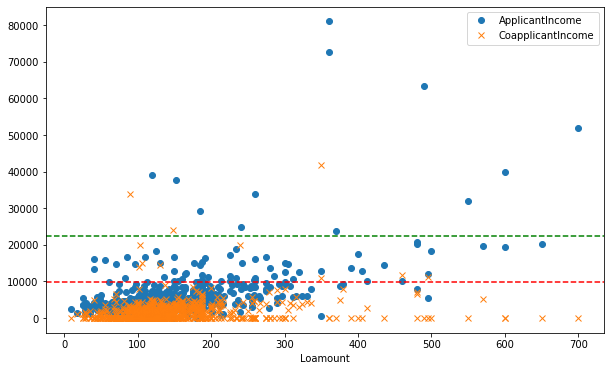

In [119]:
ax = filt_data.plot.line(x="Loamount", y=["ApplicantIncome", "CoapplicantIncome"], figsize=(10,6), style=["o", "x"])
ax.axhline(filt_data["ApplicantIncome"].mean() + 3*filt_data["ApplicantIncome"].std(), color="green", linestyle="dashed")
ax.axhline(filt_data["CoapplicantIncome"].mean() + 3*filt_data["CoapplicantIncome"].std(), color="red", linestyle="dashed")
pyplot.show()

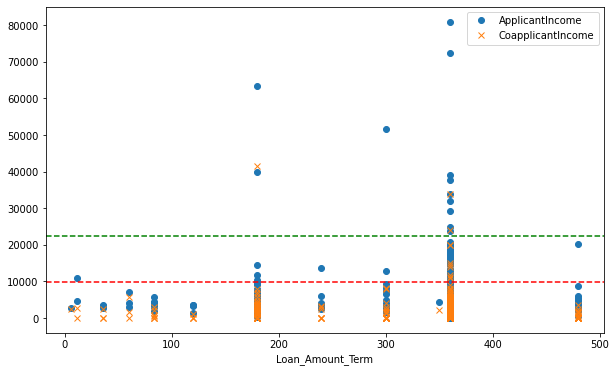

In [120]:
ax = filt_data.plot.line(x="Loan_Amount_Term", y=["ApplicantIncome", "CoapplicantIncome"], figsize=(10,6), style=["o", "x"])
ax.axhline(filt_data["ApplicantIncome"].mean() + 3*filt_data["ApplicantIncome"].std(), color="green", linestyle="dashed")
ax.axhline(filt_data["CoapplicantIncome"].mean() + 3*filt_data["CoapplicantIncome"].std(), color="red", linestyle="dashed")
pyplot.show()

As evident from both the graphs:
* Not a linear variationn of *ApplicantIncome* or *CoapplicantIncome* w.r.t. *Loamount*.
* The 3-Std line enough to keep the outliers out of the data.

Hence it is better to spot outliers using box plot and using information from quantiles as above for these columns.

<AxesSubplot:>

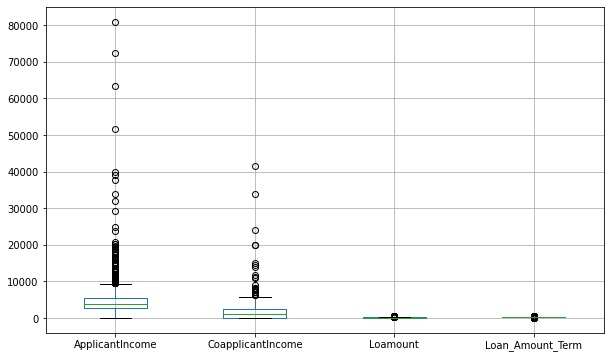

In [121]:
filt_data[DataColumns.continuous].boxplot(figsize=(10,6))

C:\Users\THUNDE~1\AppData\Local\Temp/ipykernel_14356/3818479515.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_data["z_" + col] = zscore(filt_data[col])


<AxesSubplot:>

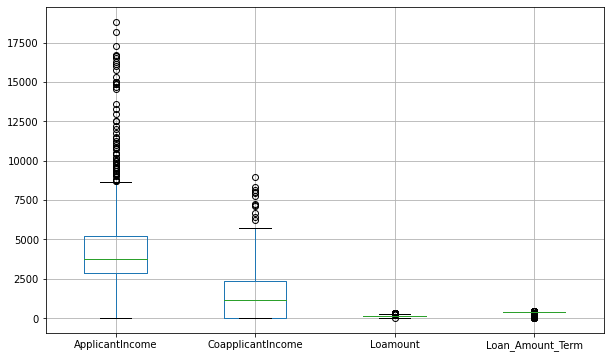

In [122]:
from scipy.stats import zscore

for col in DataColumns.continuous:
    filt_data["z_" + col] = zscore(filt_data[col])
    filt_data = filt_data[filt_data["z_" + col] < 3]
    filt_data.reset_index(drop=True, inplace=True)

filt_data[DataColumns.continuous].boxplot(figsize=(10,6))

Comparing both the box plots, it is clear that after removing points beyond 3 Std., all values above 20000 in *ApplicantIncome* and 10000 in *CoapplicantIncome* have been removed.

### Label Encoding

In [123]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
filt_data["Credit_History"] = filt_data["Credit_History"].astype(str)
filt_data["Dependents"] = filt_data["Dependents"].astype(str)

for col in DataColumns.categorical+[DataColumns.target]:
    filt_data[col] = encoder.fit_transform(filt_data[col])

ppx_data = filt_data[DataColumns.categorical + DataColumns.continuous + [DataColumns.target]]
ppx_data.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,ApplicantIncome,CoapplicantIncome,Loamount,Loan_Amount_Term,Loan_Status
0,1,1,1,0,0,1,0,4583,1508.0,128.0,360,0
1,1,1,0,0,1,1,2,3000,0.0,66.0,360,1
2,1,1,0,1,0,1,2,2583,2358.0,120.0,360,1
3,1,0,0,0,0,1,2,6000,0.0,141.0,360,1
4,1,1,2,0,1,1,2,5417,4196.0,267.0,360,1


### Check Class Balance

In [124]:
ppx_data[DataColumns.target].value_counts(normalize=True)

1    0.74345
0    0.25655
Name: Loan_Status, dtype: float64

Approximately 75% isto 25%, which is enough to proceed with. Just we need to make sure the same variation when we split the data.

## Status Prediction

### Split Data

In [125]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ppx_data[DataColumns.categorical + DataColumns.continuous], ppx_data[DataColumns.target], test_size = 0.2)
print("Size of train set: {} or {} %".format(X_train.shape, round(len(X_train)*100/len(ppx_data), 2)))
print("Size of test set: {} or {} %".format(X_test.shape, round(len(X_test)*100/len(ppx_data), 2)))

Size of train set: (732, 11) or 79.91 %
Size of test set: (184, 11) or 20.09 %


In [126]:
# Check Balance in Train
y_train.value_counts(normalize=True)

1    0.730874
0    0.269126
Name: Loan_Status, dtype: float64

In [127]:
# Check Balance in Test
y_test.value_counts(normalize=True)

1    0.793478
0    0.206522
Name: Loan_Status, dtype: float64

Approximately similar balance as the original data, hence good to proceed else we'd need to shuffle again.

### Creating Model

Let's begin with Bagging technique to create an estimator for the purpose. The technique is implemented efficiently by a *Random Forest Classifier* that balances *Bias* and *Variance* trade-off effectively. Along with this, we'll train the estimator in *Grid Search Cross Validation* format, that will let us have the tuned estimator over the choice of hyperparameters provided.

In [128]:
from sklearn.metrics import fbeta_score, make_scorer

def f_beta(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta = 0.85)

f_beta_score = make_scorer(f_beta, greater_is_better=True)

In [129]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    "n_estimators": [80, 100, 120],
    "criterion": ["gini", "entropy"],
    "max_depth": [4, 6, 8],
    "max_features": [3, 6, 9],
    "oob_score": [True],
    "n_jobs": [3],
    "class_weight": ["balanced_subsample"]
}

rf_estimator = RandomForestClassifier()
classifier = GridSearchCV(estimator = rf_estimator, param_grid=params, scoring=f_beta_score, n_jobs=2, cv=3)
classifier.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'class_weight': ['balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8], 'max_features': [3, 6, 9],
                         'n_estimators': [80, 100, 120], 'n_jobs': [3],
                         'oob_score': [True]},
             scoring=make_scorer(f_beta))

In [130]:
classifier.best_estimator_

RandomForestClassifier(class_weight='balanced_subsample', max_depth=8,
                       max_features=9, n_estimators=80, n_jobs=3,
                       oob_score=True)

In [131]:
classifier.best_score_

0.9122594885731793

### Evaluating Model

In [132]:
from sklearn.metrics import classification_report

target_names = list(encoder.inverse_transform(ppx_data[DataColumns.target].unique()))

# Train
print(classification_report(y_true = y_train, y_pred = classifier.predict(X_train), target_names = target_names))

              precision    recall  f1-score   support

           N       0.99      0.86      0.92       197
           Y       0.95      1.00      0.97       535

    accuracy                           0.96       732
   macro avg       0.97      0.93      0.95       732
weighted avg       0.96      0.96      0.96       732



In [133]:
# Test
print(classification_report(y_true = y_test, y_pred = classifier.predict(X_test), target_names = target_names))

              precision    recall  f1-score   support

           N       0.80      0.53      0.63        38
           Y       0.89      0.97      0.92       146

    accuracy                           0.88       184
   macro avg       0.84      0.75      0.78       184
weighted avg       0.87      0.88      0.86       184



Now, we started our algorithm creation with the following objectives:
1. High Precision - Critical factor
2. High Accuracy - Important factor

Observing our model performance over both the sets:
1. All the metric scores are very close, which implies our model is *very well generalized*.
2. The *Precision* for negative cases in test set is 100% for the test set, hence meeting our objective for the critical factor. Hence the model is tuned to detect the cases of loan defaults.
3. The *Accuracy* for the test set is good enough at 88%, hence meeting our next objective. The accuracy can further be imporved using boosting technique or trying other models and creating an ensemble.